In [197]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
print(torch.__version__)
import matplotlib.dates as mdates

2.1.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amwright/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [172]:
data_random = pd.read_csv('../data/processed/train_random_subset.csv')
data_curseword = pd.read_csv('../data/processed/train_cursewords.csv')

In [173]:
data_random.columns.tolist()

['Employee',
 'Type',
 'Date',
 'To',
 'From',
 'Subject',
 'Body',
 'doc_sentiment',
 'curse_words',
 'ethically_questionable',
 'business_personal']

In [174]:
data_random = data_random[data_random['doc_sentiment'].notna()]
data_curseword = data_curseword[data_curseword['doc_sentiment'].notna()]
full_data = pd.concat([data_random, data_curseword]).sample(frac=1).reset_index(drop=True)[['Body', 'doc_sentiment']].rename(columns={"Body":"content"})
full_data['sentiment'] = full_data.apply(lambda row: 0 if row['doc_sentiment']=='negative' else 1 if row['doc_sentiment']=='neutral' else 2, axis=1)
data = full_data[['content','sentiment']]

In [111]:
print(f"Number of Documents: {len(data)}")
display(data.head())

Number of Documents: 914


,content,sentiment
0,I am totally remiss! I am only now sending ...,0
1,seeing no increase in physical demand from in...,0
2,the bitch would like you to change the 1.5 MM ...,0
3,Chad and Pig: in light of the contract being ...,0
4,the damned book costs $100! i've borrowed you...,0


In [112]:
print(data.sentiment.value_counts())

data_neutral = data[data['sentiment']==1]
data_not_neutral = data[data['sentiment']!=1]

data_neutral_sampled = data_neutral.sample(frac=0.4)

data = pd.concat([data_neutral_sampled, data_not_neutral]).sample(frac=1)
print(data.sentiment.value_counts())

sentiment
1    551
0    214
2    149
Name: count, dtype: int64
sentiment
1    220
0    214
2    149
Name: count, dtype: int64


In [113]:
X = data.content.values
y = data.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [114]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [115]:
# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

Best alpha:  0.7


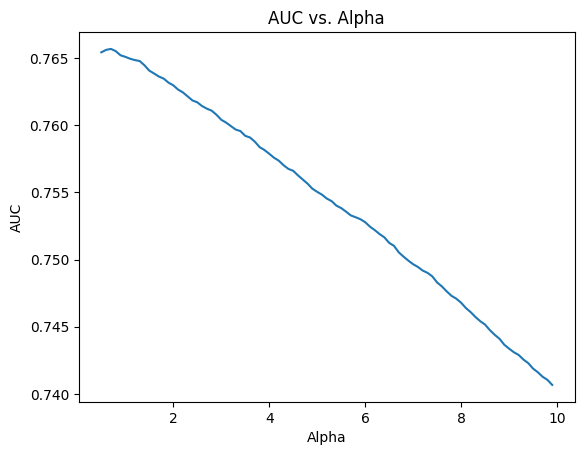

In [116]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation, adapted for multiclass targets.
    """
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Perform cross-validation and get predictions
    y_pred = cross_val_predict(model, X_train_tfidf, y_train, cv=kf, method='predict_proba')

    # Binarize the output classes
    y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))

    if y_train_binarized.shape[1] == 1:  # binary case
        return roc_auc_score(y_train, y_pred[:, 1])

    # Compute AUC for each class and average
    auc_scores = roc_auc_score(y_train_binarized, y_pred, multi_class='ovr', average='macro')
    
    return auc_scores

res = pd.Series([get_auc_CV(MultinomialNB(alpha=i))
                 for i in np.arange(0.5, 10, 0.1)],
                index=np.arange(0.5, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

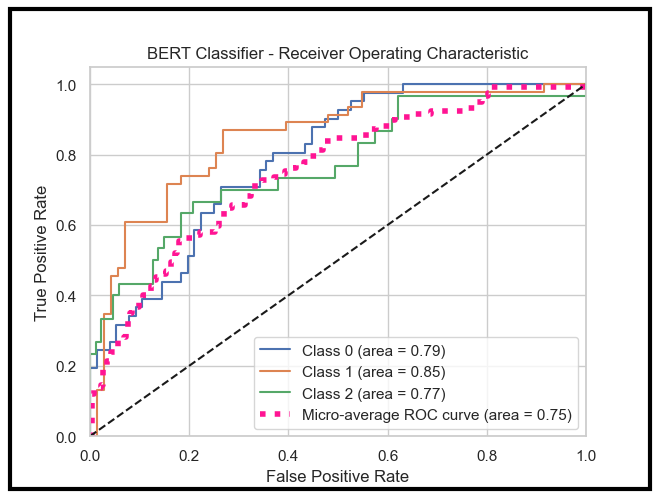

Accuracy: 57.26%


In [314]:
def evaluate_roc(probs, y_true, classes):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities
    @params    y_true (np.array): an array of the true values
    @params    classes (list): list of unique class labels
    """
    y_true_binarized = label_binarize(y_true, classes=classes)  # Binarize the output
    n_classes = y_true_binarized.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class and micro-average
    fig, ax = plt.subplots()

    import matplotlib.patches as patches

    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=fig.transFigure, linewidth=3, edgecolor='black', facecolor='none', zorder=-1
    )
    fig.patches.extend([rect])
    #plt.title('Receiver Operating Characteristic')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('BERT Classifier - Receiver Operating Characteristic')
    plt.show()

    # Get accuracy over the test set
    y_pred = np.argmax(probs, axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

# Assuming X_train_tfidf, X_test_tfidf, y_train, y_test are already defined and MultinomialNB is imported
classes = np.unique(y_train)  # Get the list of unique class labels

# Train the model
nb_model = MultinomialNB(alpha=0.7, fit_prior=True)
nb_model.fit(X_train_tfidf, y_train)

# Compute predicted probabilities
probs = nb_model.predict_proba(X_test_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_test, classes)


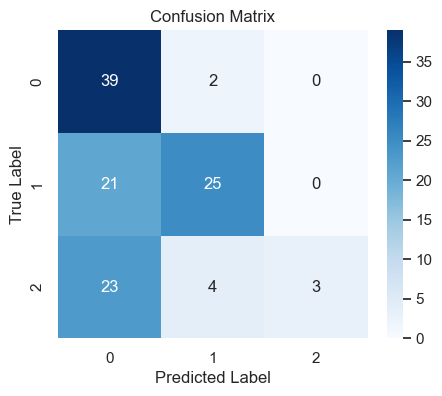

In [312]:
# Predict the test set results
y_pred = nb_model.predict(X_test_tfidf)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix in a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [119]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [120]:
# Concatenate train data and test data

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in data.content.values]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_text])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1403 > 512). Running this sequence through the model will result in indexing errors


Max length:  3814


In [121]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
#print('Original: ', X[0])
#print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/Users/amwright/.local/share/virtualenvs/enron-lAM3SukH/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [122]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [123]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [124]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [125]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [126]:
import random
import time

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model."""
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation:
            # After the completion of each training epoch, measure the model's performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
    print("\n")
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance on our validation set."""
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy



In [127]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

/Users/amwright/.local/share/virtualenvs/enron-lAM3SukH/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   14    |   1.020299   |     -      |     -     |  534.79  
----------------------------------------------------------------------
   1    |    -    |   1.020299   |  0.930067  |   54.54   |  553.66  
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   14    |   0.797511   |     -      |     -     |  573.84  
----------------------------------------------------------------------
   2    |    -    |   0.797511   |  0.836112  |   61.24   |  592.53  
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------------

In [132]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """
    Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()
    
    all_logits = []
    
    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    
    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    
    return probs


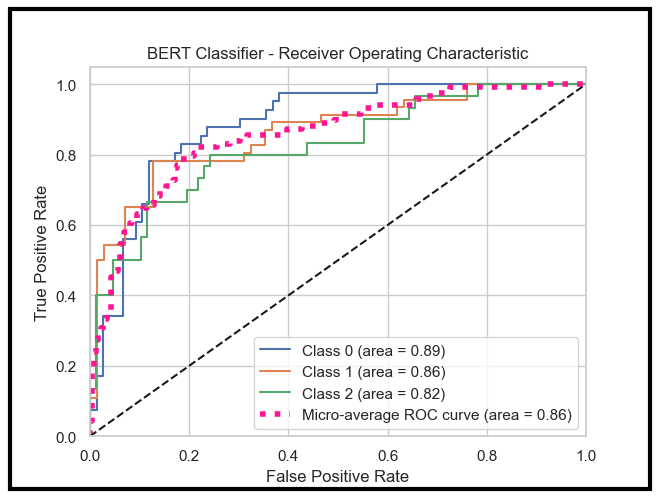

Accuracy: 69.23%
[2 0 0 2 0 0 2 1 1 2 1 2 1 1 1 1 0 0 0 1 2 1 0 0 1 2 0 2 1 2 2 0 1 0 1 1 1
 2 2 0 2 2 0 0 0 2 1 1 0 1 1 0 2 0 1 0 2 0 2 0 0 0 0 1 1 1 2 2 1 2 0 0 2 1
 0 0 0 2 1 1 1 1 1 1 0 0 2 1 1 1 2 2 1 2 2 2 0 1 0 1 0 2 1 0 1 1 0 1 0 1 0
 0 1 1 0 1 1]


In [319]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# Evaluate the Bert classifier
evaluate_roc(probs, y_test, classes=np.unique(y_train))
print(y_test)

Positive Class Precision: 0.65
Positive Class Recall : 0.67
Positive Class F1: 0.66


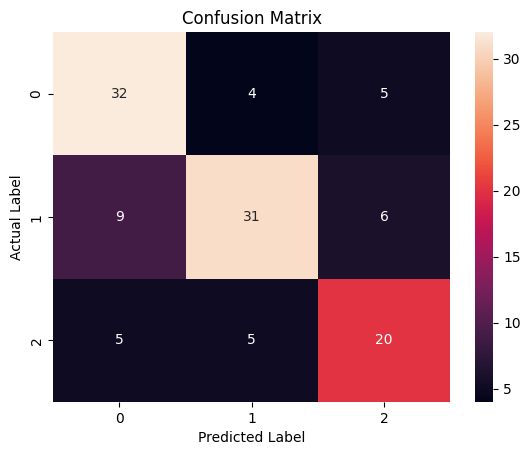

In [146]:
probs_list = probs.tolist()

positive_probabilites = []
for item in probs_list:
    positive_probabilites.append(item[2])
positive_probabilites = sorted(positive_probabilites, reverse=True)

def create_predictions(probs):
    predictions = []
    for prob in probs:
        if prob[2] >= 0.35:
            predictions.append(2)
        else:
            prediction = prob.index(max(prob))
            predictions.append(prediction)

    return predictions


predictions = create_predictions(probs_list)

# Step 3: Create the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

false_positives = conf_matrix[0][2]+conf_matrix[1][2]
false_negatives = conf_matrix[2][0]+conf_matrix[2][1]
true_positives = conf_matrix[2][2]
precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)
print(f'Positive Class Precision: {round(precision,2)}')
print(f'Positive Class Recall : {round(recall,2)}')
print(f'Positive Class F1: {round((2 * precision * recall)/(precision+recall),2)}')

# Now you have the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [147]:
correct_predictions = np.trace(conf_matrix)

# Total number of predictions
total_predictions = np.sum(conf_matrix)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.7094017094017094


In [207]:
full_inference_data = pd.read_csv('../data/processed/full_dataset.csv').rename(columns={'Body':'content'})
inference_data = full_inference_data[['content']]
inference_data = inference_data[inference_data['content'].notna()]
display(inference_data.head())
print(len(full_inference_data))

,content
0,Hey there. We are going to be at Front Porch...
1,John- Was lovely meeting you this weekend. ...
2,Qwiklist(9) MyAccount Rental History ...
3,"John, As discussed, the AIG exposure is $57M..."
4,Happy New Year and best wishes. - Energy010...


148547


In [208]:
inference_data_trim = (pd.merge(inference_data,data[['content']], indicator=True, how='outer', on='content')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))

print(len(inference_data)-len(inference_data_trim))
print(len(inference_data_trim))
display(inference_data_trim.head())


print(len(inference_data_trim))

2853
145506


,content
0,Hey there. We are going to be at Front Porch...
1,John- Was lovely meeting you this weekend. ...
2,Qwiklist(9) MyAccount Rental History ...
3,"John, As discussed, the AIG exposure is $57M..."
4,Happy New Year and best wishes. - Energy010...


145506


In [209]:
inference_inputs, inference_masks = preprocessing_for_bert(inference_data_trim.content)
# Create the DataLoader for our inference set
inference_dataset = TensorDataset(inference_inputs, inference_masks)
inference_sampler = SequentialSampler(inference_dataset)
inference_dataloader = DataLoader(inference_dataset, sampler=inference_sampler, batch_size=32)

/Users/amwright/.local/share/virtualenvs/enron-lAM3SukH/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [210]:
# Compute predicted probabilities on the inference set
probs_inference = bert_predict(bert_classifier, inference_dataloader)

predictions = create_predictions(probs_inference.tolist())

In [211]:
inference_data_trim['prediction'] = predictions
inference_data_trim.prediction.value_counts()

prediction
1    107584
0     21778
2     16144
Name: count, dtype: int64

In [212]:
results = inference_data_trim.merge(full_inference_data.drop_duplicates(subset=['content']), on='content', how='left')[['fixed_date','Employee','Type','From','To','Subject','content','prediction']]
print(len(results))
display(results.head())

145506


,fixed_date,Employee,Type,From,To,Subject,content,prediction
0,2001-10-25,arnold-j,received,Kimberly Banner,NaN,hi,Hey there. We are going to be at Front Porch...,2
1,2001-11-27,arnold-j,received,Kelly Busch,NaN,keeping the lights on,John- Was lovely meeting you this weekend. ...,0
2,2001-12-31,arnold-j,received,customerservice@qwikfliks.com,NaN,L.A. Confidential has been received.,Qwiklist(9) MyAccount Rental History ...,1
3,2001-11-20,arnold-j,received,Tanya Rohauer,NaN,AIG positions,"John, As discussed, the AIG exposure is $57M...",1
4,2002-01-01,arnold-j,received,Mark Sagel,NaN,Market update,Happy New Year and best wishes. - Energy010...,2


In [213]:
tqdm.pandas()
results['prediction_value'] = results.progress_apply(lambda row: -1 if row['prediction'] == 0 else 1 if row['prediction'] == 2 else 0, axis=1)

100%|██████████| 145506/145506 [00:00<00:00, 351145.85it/s]


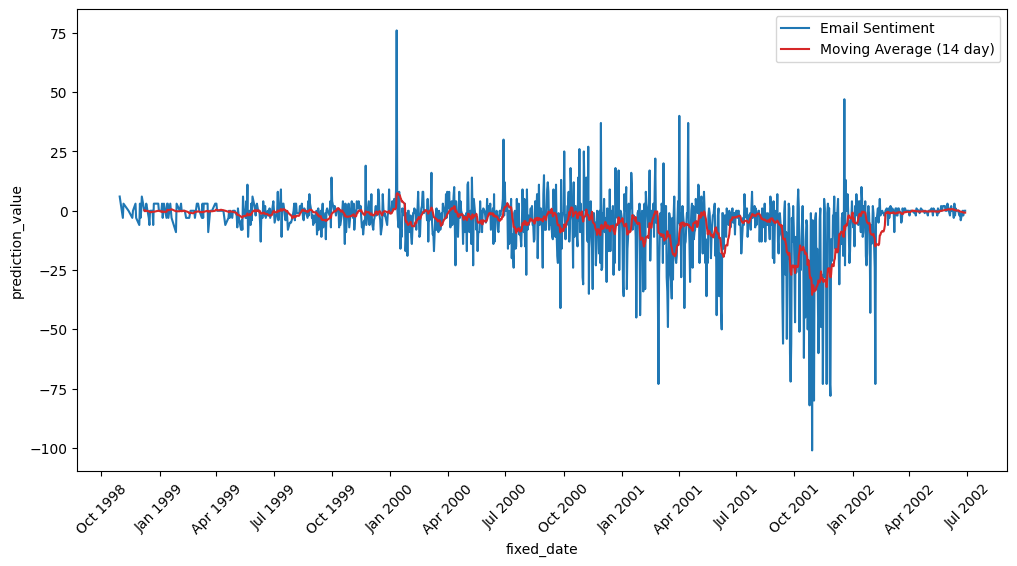

In [241]:
results_grouped_date = results.groupby(by='fixed_date').prediction_value.sum().reset_index()

results_grouped_date['fixed_date'] = pd.to_datetime(results_grouped_date['fixed_date'])

# Define start and end dates
start_date = pd.Timestamp('1998-09-01')
end_date = pd.Timestamp('2002-06-30')

# Create the mask for dates between the start_date and end_date
mask = (results_grouped_date['fixed_date'] >= start_date) & (results_grouped_date['fixed_date'] <= end_date)

results_grouped_date = results_grouped_date[mask]

results_grouped_date['MA14'] = results_grouped_date['prediction_value'].rolling(window=14).mean()


fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=results_grouped_date, x='fixed_date', y='prediction_value', label='Email Sentiment', color='tab:blue')
sns.lineplot(data=results_grouped_date, x='fixed_date', y='MA14', label='Moving Average (14 day)', color='tab:red')



ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.show()

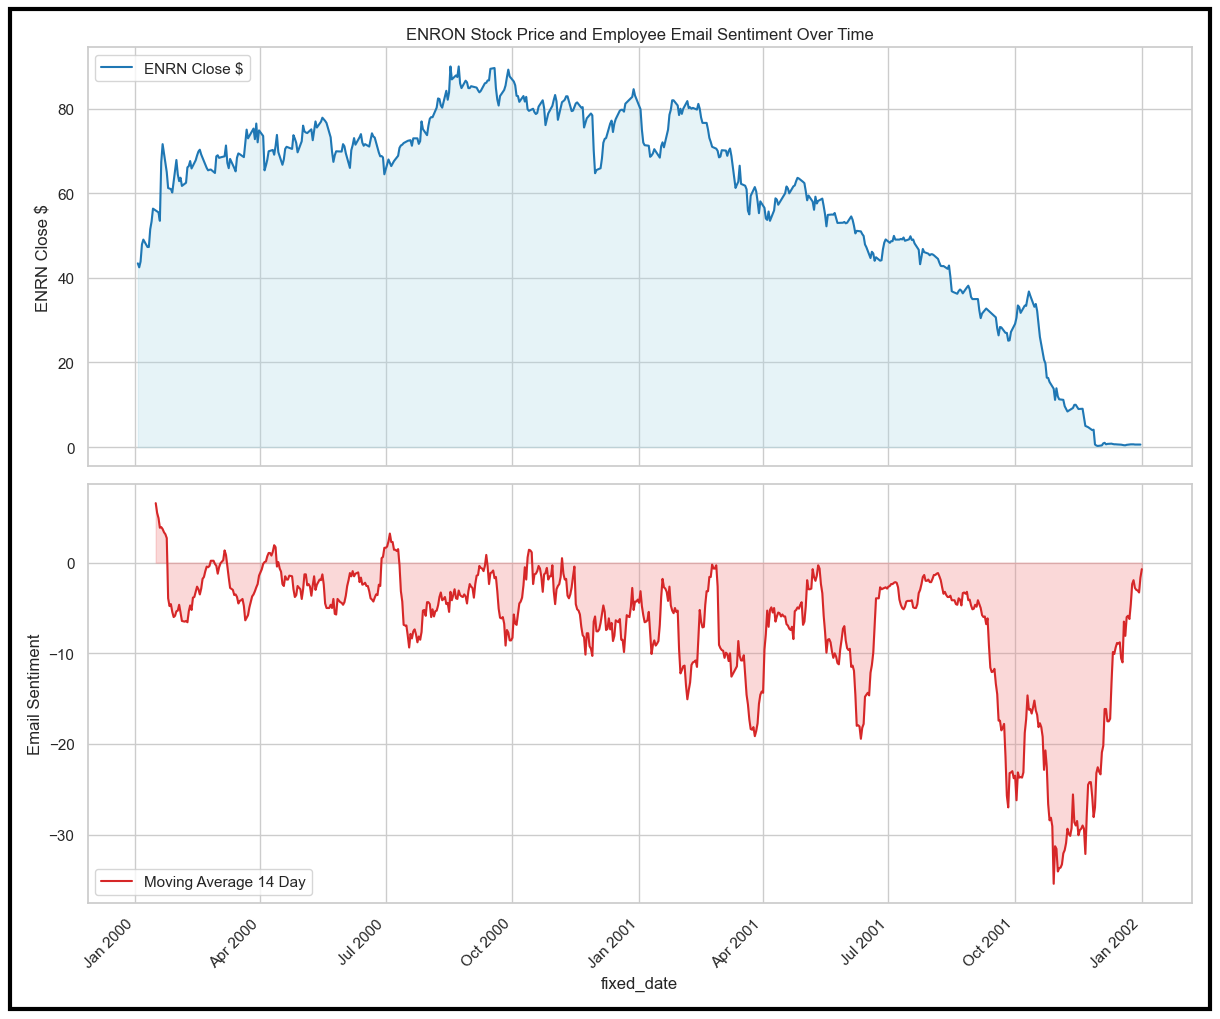

In [307]:
stock_data = pd.read_csv('../data/raw/enron_stock_price.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
#display(stock_data.head())


results_grouped_date = results.groupby(by='fixed_date').prediction_value.sum().reset_index()

results_grouped_date['fixed_date'] = pd.to_datetime(results_grouped_date['fixed_date'])

# Define start and end dates
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('2002-01-01')

# Create the mask for dates between the start_date and end_date
mask = (results_grouped_date['fixed_date'] >= start_date) & (results_grouped_date['fixed_date'] <= end_date)
results_grouped_date = results_grouped_date[mask]

mask = (stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)
stock_data = stock_data[mask]

results_grouped_date['MA14'] = results_grouped_date['prediction_value'].rolling(window=14).mean()

import matplotlib.patches as patches

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)
rect = patches.Rectangle(
    (0, 0), 1, 1, transform=fig.transFigure, linewidth=3, edgecolor='black', facecolor='none', zorder=-1
)

# Add the patch to the figure
fig.patches.extend([rect])

#sns.set_theme(style="whitegrid")

# Plot the stock closing price data on the first subplot
ax1.fill_between(stock_data['Date'], stock_data['Close'], alpha=0.3, color='lightblue')
sns.lineplot(data=stock_data, x='Date', y='Close', label='ENRN Close $', color='tab:blue', ax=ax1)
ax1.set_ylabel('ENRN Close $')
ax1.legend(loc='upper left')
ax1.set_title('ENRON Stock Price and Employee Email Sentiment Over Time')

# Shade the area above the prediction_value line in the second subplot
ax2.fill_between(results_grouped_date['fixed_date'], results_grouped_date['MA14'], alpha=0.3, color='lightcoral')
sns.lineplot(data=results_grouped_date, x='fixed_date', y='MA14', label='Moving Average 14 Day', color="tab:red", ax=ax2)
ax2.set_ylabel('Email Sentiment')
ax2.legend(loc='lower left')

# Set up the x-axis with major ticks and formatter
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=45)  # Automatically format the x-axis dates and rotate

plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [316]:
results.to_csv('../data/processed/full_data_w_predictions.csv')

In [317]:
results_grouped_date.to_csv('../data/processed/full_data_w_predictions_grouped_by_date.csv')